Problem statement (realistic):
Build a model to forecast daily AQI for Karachi to support air-quality alerts, planning, and health advisories.

Decision this data will support

1. Can we trust this dataset enough to train a forecasting model?

2. Is AQI behavior stable and learnable, or too noisy / broken?

3. Which features are actually predictive vs junk?

AQI EDA hypotheses

- H1: AQI data coverage is consistent over time (no long silent gaps)
- H2: Missing AQI values are NOT random and follow a pattern
- H3: AQI distribution is stable enough to be forecastable
- H4: Weather features correlate with AQI in expected directions
- H5: Extreme AQI spikes are rare and explainable, not data errors
- H6: Data leakage does not exist (no future information)


Data Source:
- AQI: External AQI API
- Weather: External Weather API

Storage:
- MongoDB
- Database: aqi_feature_store
- Collection: raw_aqi_weather_daily

Data Type:
- Raw daily aggregates (NOT user-modified)
- One row per city per day


In [10]:
import sys
import os

# Step 1: Set PROJECT_ROOT to one level above notebooks
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

print("Project root added to sys.path:", PROJECT_ROOT)

# Step 2: Imports after setting sys.path
from datetime import datetime, timedelta
from src.ingestion.merge_data import merge_historical_data

# Step 3: Replace with your AQICN token
token = "361cf32474f50ec4ff9f3f677392739e1bfd8384"

# Step 4: Fetch merged historical data
historical_df = merge_historical_data(city="karachi", token=token)

# Step 5: Quick sanity check
print("Merged historical data loaded. Shape:", historical_df.shape)
display(historical_df.head())


Project root added to sys.path: c:\Users\NAWAB AHMAD\aqi-forecasting-mlops
Project root added to sys.path: c:\Users\NAWAB AHMAD\aqi-forecasting-mlops\notebooks


[2026-01-28 03:03:58,194] [INFO] src.ingestion.merge_data - Fetching and merging historical data for karachi
[2026-01-28 03:03:58,195] [INFO] src.ingestion.station_resolver - Resolving AQICN station
[2026-01-28 03:03:59,446] [INFO] src.ingestion.station_resolver - Station resolved
[2026-01-28 03:03:59,448] [INFO] src.ingestion.openmeteo_historical_client - Fetching historical AQI from Open-Meteo
[2026-01-28 03:04:00,451] [INFO] src.ingestion.openmeteo_historical_client - Historical AQI normalized
[2026-01-28 03:04:00,746] [INFO] src.ingestion.openmeteo_weather_historical_client - Fetching historical weather from Open-Meteo
[2026-01-28 03:04:02,303] [INFO] src.ingestion.openmeteo_weather_historical_client - Historical weather normalized
[2026-01-28 03:04:02,643] [INFO] src.ingestion.merge_data - Merged historical data shape: (2904, 19)


Merged historical data loaded. Shape: (2904, 19)


,city_x,event_timestamp,source_x,ingested_at_x,pm25_pollutants,pm10_pollutants,no2_pollutants,so2_pollutants,o3_pollutants,co_pollutants,city_y,source_y,ingested_at_y,temperature_weather,humidity_weather,wind_speed_weather,wind_direction_weather,pressure_weather,precipitation_weather
0,karachi,2025-09-29 00:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.7,58.3,8.5,6.9,41.0,140.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,25.9,97.0,10.4,324.0,1002.2,0.0
1,karachi,2025-09-29 01:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.8,55.1,14.7,8.4,35.0,295.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,99.0,10.1,321.0,1002.5,0.0
2,karachi,2025-09-29 02:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,28.2,52.7,23.2,10.5,28.0,507.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,97.0,9.3,326.0,1002.8,0.0
3,karachi,2025-09-29 03:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,31.7,49.8,27.9,12.9,35.0,665.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,27.4,87.0,8.5,325.0,1003.0,0.0
4,karachi,2025-09-29 04:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,30.7,44.4,25.7,15.9,70.0,711.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,30.2,71.0,8.6,331.0,1003.3,0.0


In [14]:
# --- Cell 1: Dataset sanity check ---
import pandas as pd

print("Shape:", historical_df.shape)
print("\nColumns:")
for col in historical_df.columns:
    print(f" - {col}")

print("\nDate range:")
print("Start:", historical_df["event_timestamp"].min())
print("End  :", historical_df["event_timestamp"].max())

print("\nDuplicate timestamps:",
      historical_df["event_timestamp"].duplicated().sum())

display(historical_df.head(3))
display(historical_df.tail(3))


Shape: (2904, 19)

Columns:
 - city_x
 - event_timestamp
 - source_x
 - ingested_at_x
 - pm25_pollutants
 - pm10_pollutants
 - no2_pollutants
 - so2_pollutants
 - o3_pollutants
 - co_pollutants
 - city_y
 - source_y
 - ingested_at_y
 - temperature_weather
 - humidity_weather
 - wind_speed_weather
 - wind_direction_weather
 - pressure_weather
 - precipitation_weather

Date range:
Start: 2025-09-29 00:00:00+00:00
End  : 2026-01-27 23:00:00+00:00

Duplicate timestamps: 0


,city_x,event_timestamp,source_x,ingested_at_x,pm25_pollutants,pm10_pollutants,no2_pollutants,so2_pollutants,o3_pollutants,co_pollutants,city_y,source_y,ingested_at_y,temperature_weather,humidity_weather,wind_speed_weather,wind_direction_weather,pressure_weather,precipitation_weather
0,karachi,2025-09-29 00:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.7,58.3,8.5,6.9,41.0,140.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,25.9,97.0,10.4,324.0,1002.2,0.0
1,karachi,2025-09-29 01:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,25.8,55.1,14.7,8.4,35.0,295.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,99.0,10.1,321.0,1002.5,0.0
2,karachi,2025-09-29 02:00:00+00:00,open-meteo,2026-01-27 22:04:00.445529+00:00,28.2,52.7,23.2,10.5,28.0,507.0,karachi,open-meteo-weather,2026-01-27 22:04:02.297170+00:00,26.0,97.0,9.3,326.0,1002.8,0.0


,city_x,event_timestamp,source_x,ingested_at_x,pm25_pollutants,pm10_pollutants,no2_pollutants,so2_pollutants,o3_pollutants,co_pollutants,city_y,source_y,ingested_at_y,temperature_weather,humidity_weather,wind_speed_weather,wind_direction_weather,pressure_weather,precipitation_weather
2901,karachi,2026-01-27 21:00:00+00:00,open-meteo,2026-01-27 22:04:00.451627+00:00,37.7,46.9,50.7,16.6,29.0,2123.0,karachi,open-meteo-weather,2026-01-27 22:04:02.303221+00:00,16.4,57.0,5.0,69.0,1019.7,0.0
2902,karachi,2026-01-27 22:00:00+00:00,open-meteo,2026-01-27 22:04:00.451627+00:00,39.1,44.2,45.9,15.8,27.0,1627.0,karachi,open-meteo-weather,2026-01-27 22:04:02.303221+00:00,15.4,60.0,8.2,75.0,1019.6,0.0
2903,karachi,2026-01-27 23:00:00+00:00,open-meteo,2026-01-27 22:04:00.451627+00:00,39.1,42.7,39.8,15.3,26.0,918.0,karachi,open-meteo-weather,2026-01-27 22:04:02.303221+00:00,14.5,62.0,7.5,37.0,1019.5,0.0


Time frequency check

In [15]:
# --- Cell 2: Temporal resolution check ---
time_diffs = (
    historical_df["event_timestamp"]
    .sort_values()
    .diff()
    .value_counts()
)

time_diffs.head(10)


event_timestamp
0 days 01:00:00    2903
Name: count, dtype: int64

What information is missing, and how bad is it?
- Do we have holes in the story, or is it complete?

In [16]:
# --- Cell 3: Missing data overview ---
missing_summary = (
    historical_df
    .isna()
    .sum()
    .sort_values(ascending=False)
)

missing_percent = (missing_summary / len(historical_df)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_summary,
    "missing_percent": missing_percent.round(2)
})

missing_df


,missing_count,missing_percent
city_x,0,0.0
city_y,0,0.0
pressure_weather,0,0.0
wind_direction_weather,0,0.0
wind_speed_weather,0,0.0
humidity_weather,0,0.0
temperature_weather,0,0.0
ingested_at_y,0,0.0
source_y,0,0.0
co_pollutants,0,0.0


Understand air pollution over time

- How bad is the air, and does it change in patterns?


PM2.5 over time

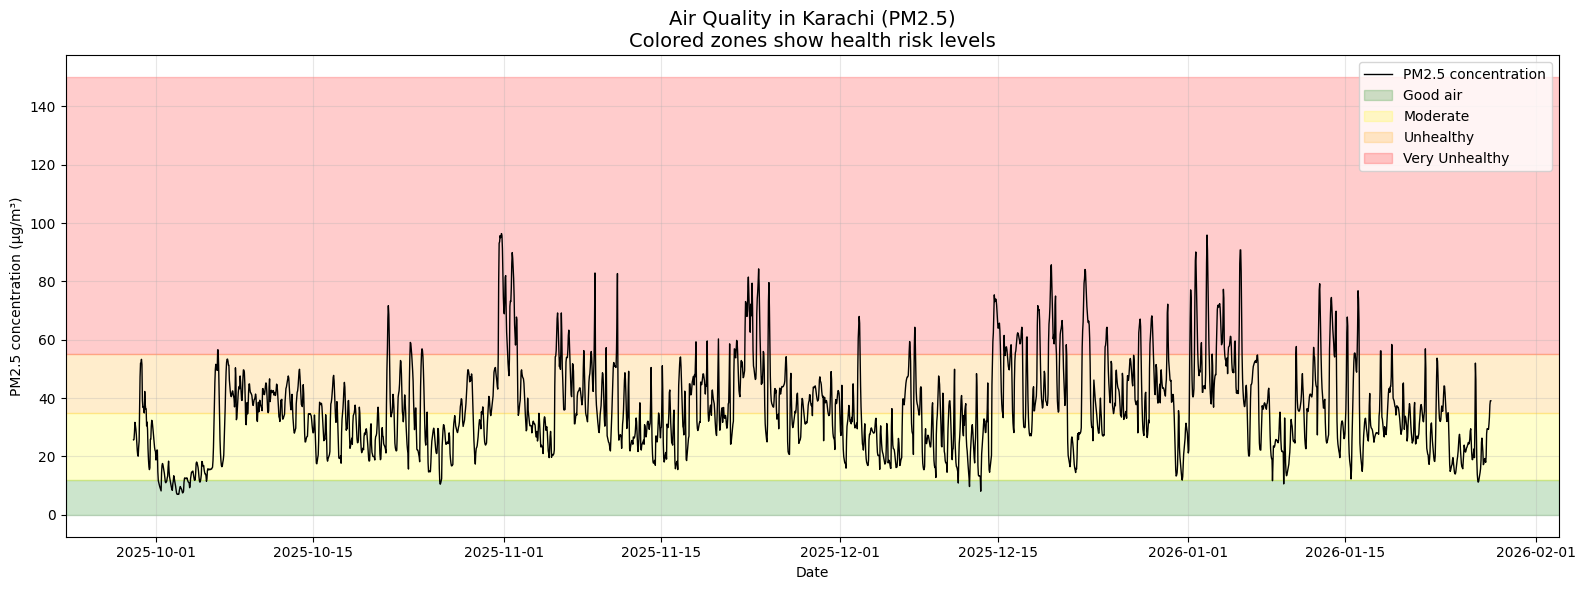

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# PM2.5 line (subtle)
plt.plot(
    historical_df["event_timestamp"],
    historical_df["pm25_pollutants"],
    color="#2c2c2c",
    linewidth=1,
    alpha=0.8
)

# Soft health bands
plt.axhspan(0, 12, color="#c8e6c9", alpha=0.6, label="Good (safe)")
plt.axhspan(12, 35, color="#fff9c4", alpha=0.6, label="Moderate")
plt.axhspan(35, 55, color="#ffe0b2", alpha=0.6, label="Unhealthy")
plt.axhspan(55, 150, color="#ffcdd2", alpha=0.6, label="Very Unhealthy")

# Titles written for humans
plt.title(
    "How Air Quality Changes Over Time in Karachi",
    fontsize=15,
    weight="bold"
)
plt.suptitle(
    "Each colored band represents how safe or dangerous the air is for health",
    fontsize=11,
    y=0.92
)

plt.xlabel("Date")
plt.ylabel("PM2.5 concentration (µg/m³)")

# Minimal grid
plt.grid(axis="y", alpha=0.2)
plt.legend(frameon=False, ncol=4, loc="upper center")

plt.tight_layout()
plt.show()


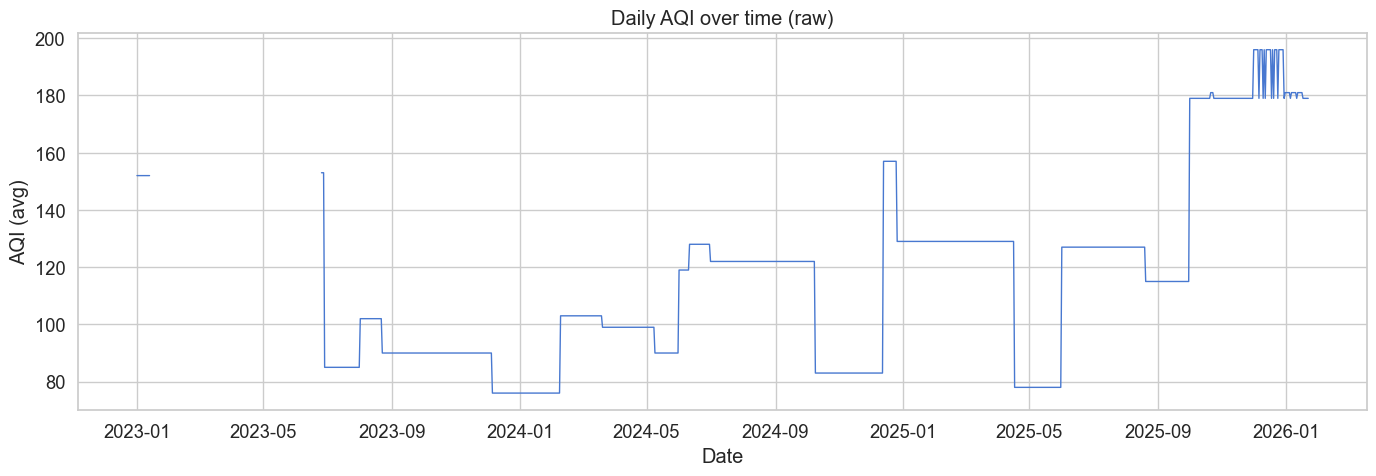

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df["date"], df["aqi_avg"], linewidth=1)
plt.title("Daily AQI over time (raw)")
plt.xlabel("Date")
plt.ylabel("AQI (avg)")
plt.tight_layout()
plt.show()


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _id                1118 non-null   object        
 1   city               1118 non-null   object        
 2   date               1118 non-null   object        
 3   aqi_avg            955 non-null    float64       
 4   aqi_max            0 non-null      object        
 5   aqi_min            0 non-null      object        
 6   created_at         1118 non-null   datetime64[ns]
 7   humidity_avg       1118 non-null   int64         
 8   precipitation_sum  1118 non-null   float64       
 9   source_aqi         1118 non-null   object        
 10  source_weather     1118 non-null   object        
 11  temperature_avg    1118 non-null   float64       
 12  temperature_max    1118 non-null   float64       
 13  temperature_min    1118 non-null   float64       
 14  wind_spe

In [15]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")


In [16]:
grain_check = (
    df.groupby(["city", "date"])
      .size()
      .reset_index(name="rows_per_city_day")
)

violations = grain_check[grain_check["rows_per_city_day"] > 1]

print("Grain violations:")
violations


Grain violations:


,city,date,rows_per_city_day


Volume, Coverage, Time Completeness

In [17]:
print("Total rows:", len(df))
print("\nRecords per city:")
print(df["city"].value_counts())

print("\nDate range per city:")
coverage = df.groupby("city")["date"].agg(["min", "max", "count"])
coverage


Total rows: 1118

Records per city:
city
Karachi    1118
Name: count, dtype: int64

Date range per city:


,min,max,count
city,,,
Karachi,2023-01-01,2026-01-22,1118


Missing date detection

In [18]:
full_dates = pd.date_range(
    start=df["date"].min(),
    end=df["date"].max(),
    freq="D"
)

missing_dates = set(full_dates.date) - set(df["date"].dt.date)

print("Missing calendar days:", len(missing_dates))


Missing calendar days: 0


Data Quality Checks

In [19]:
null_summary = df.isnull().sum().sort_values(ascending=False)
null_summary


aqi_max              1118
aqi_min              1118
aqi_avg               163
timestamp             163
_id                     0
city                    0
date                    0
created_at              0
humidity_avg            0
precipitation_sum       0
source_aqi              0
source_weather          0
temperature_avg         0
temperature_max         0
temperature_min         0
wind_speed_avg          0
dtype: int64

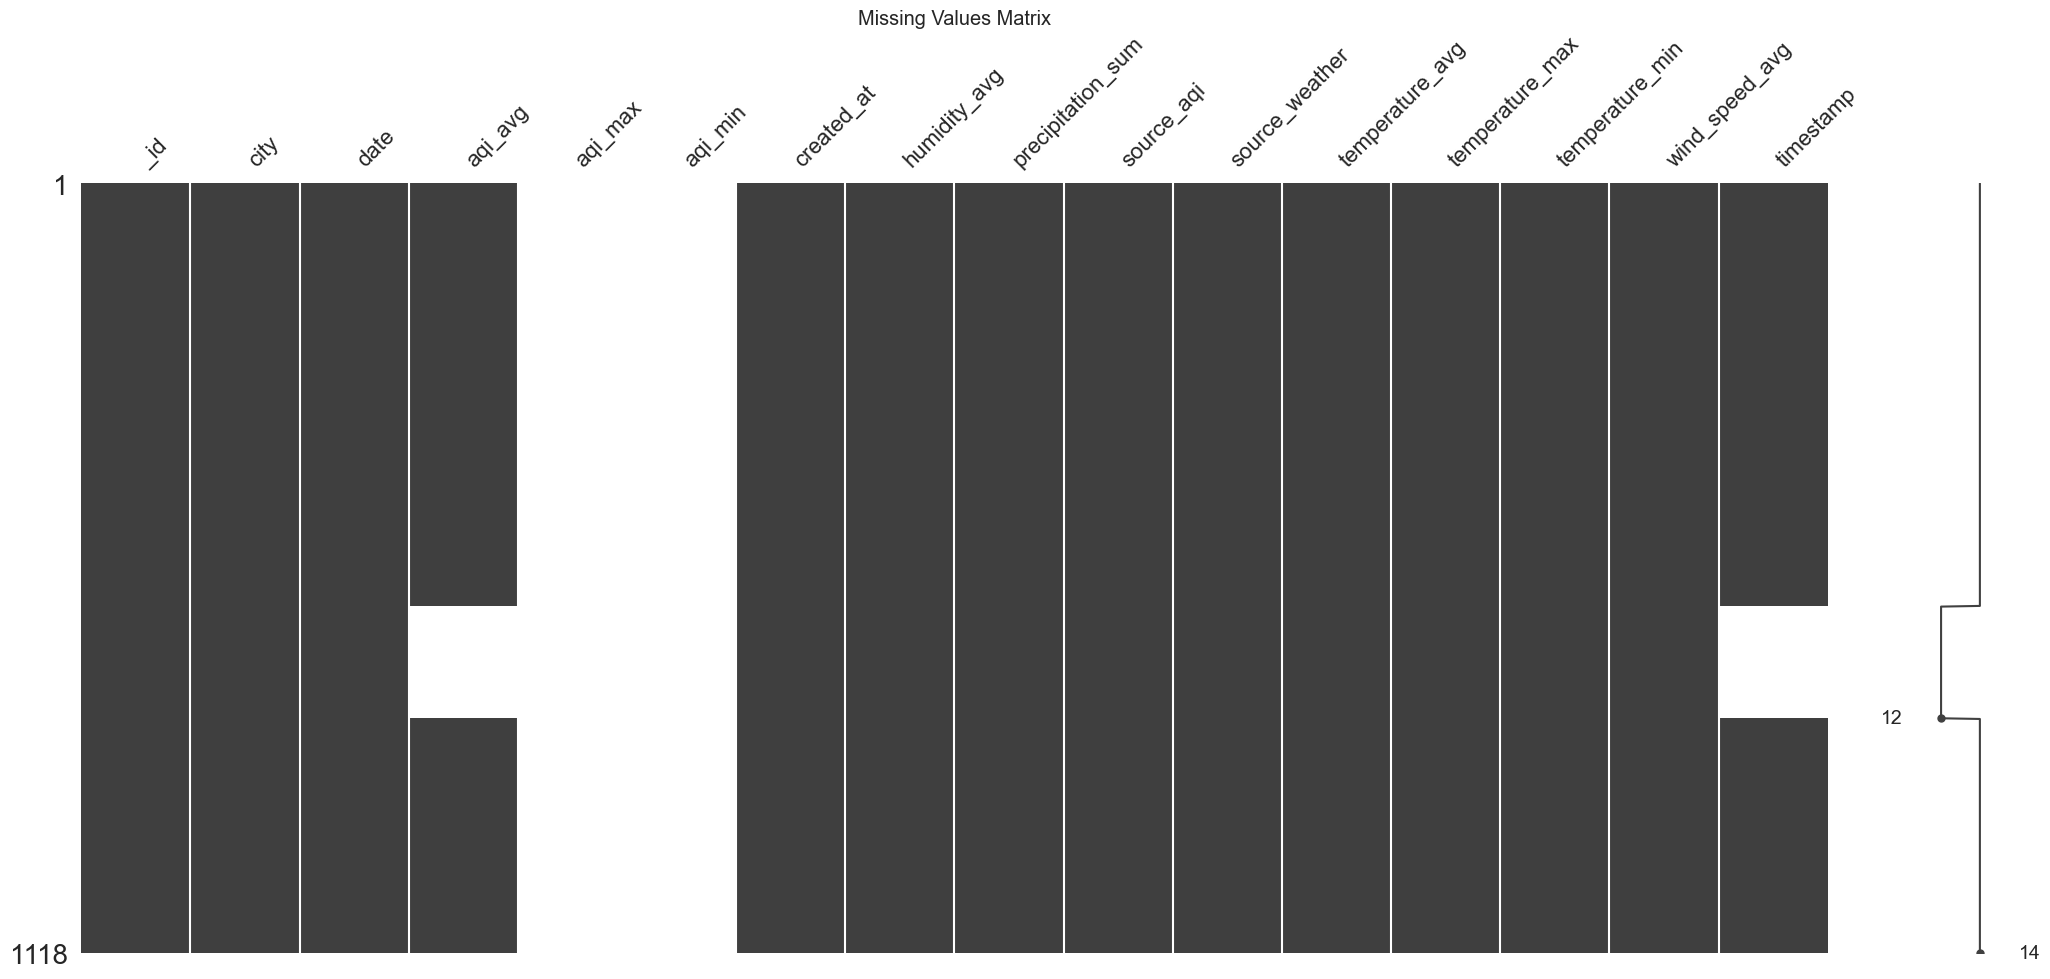

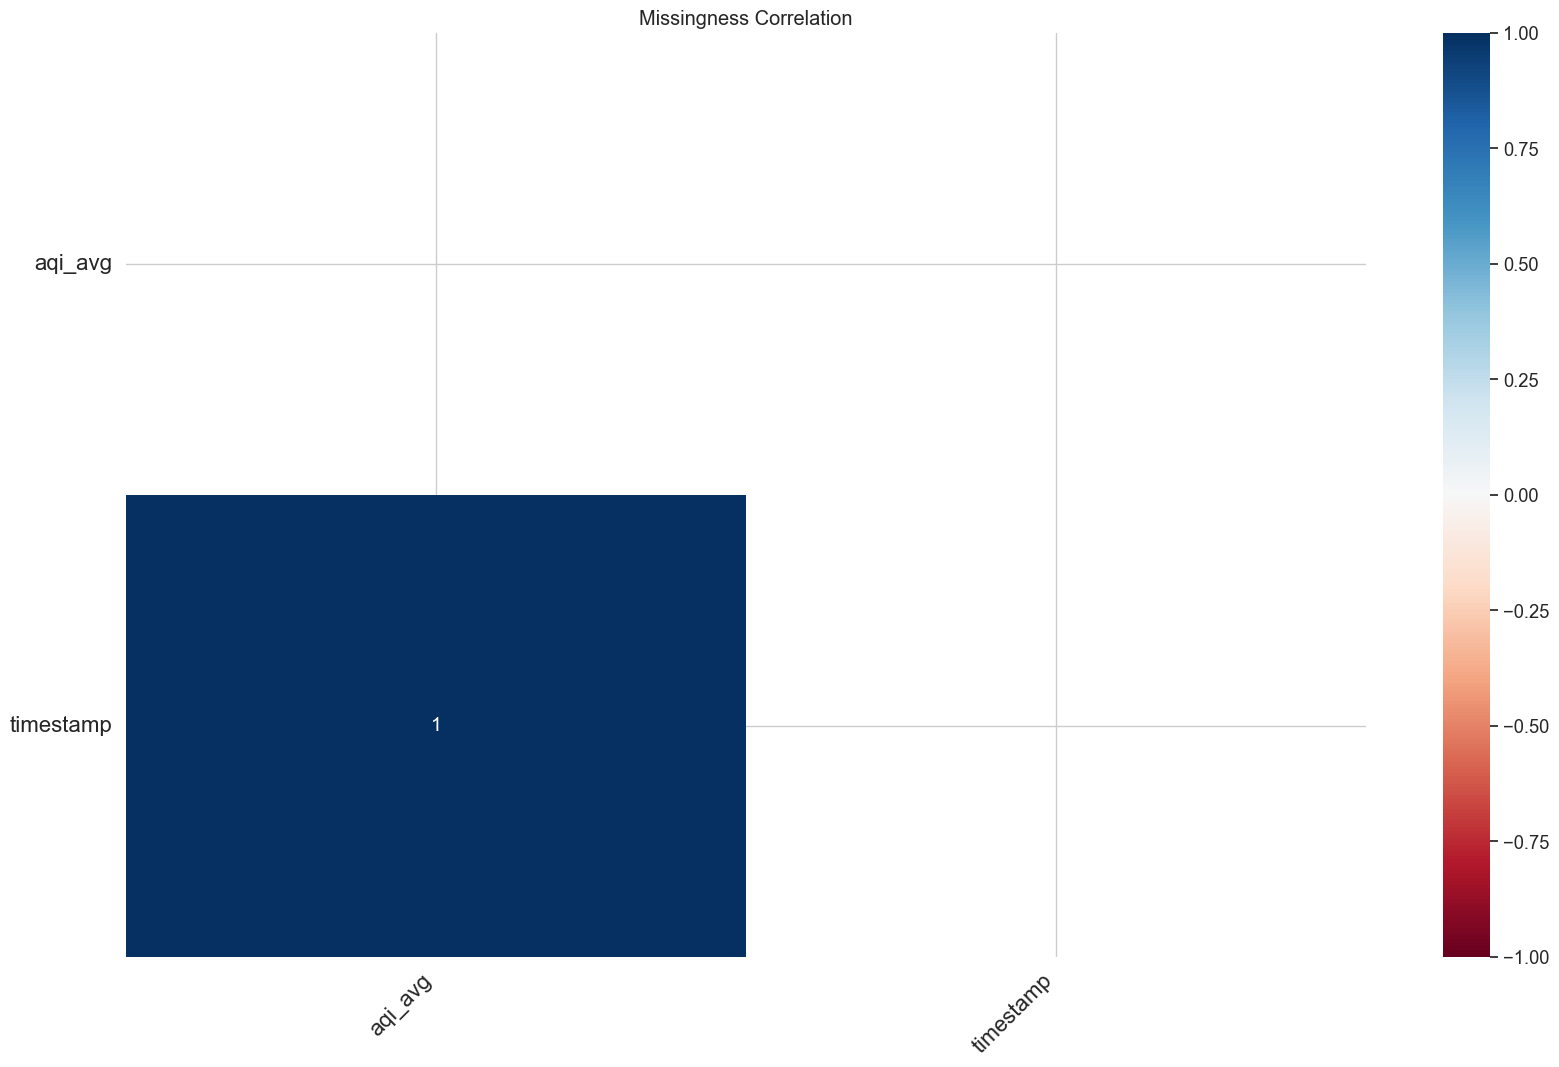

In [20]:
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

msno.heatmap(df)
plt.title("Missingness Correlation")
plt.show()


Is AQI Missing Random?

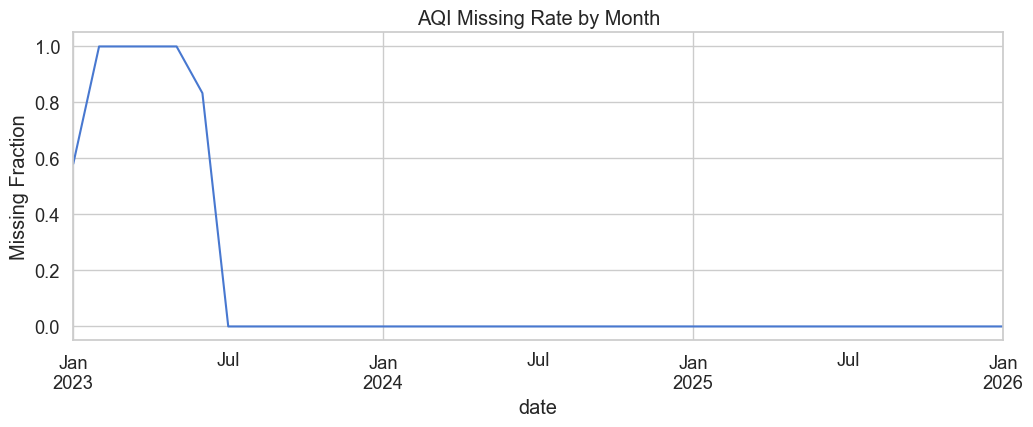

In [21]:
df["aqi_missing"] = df["aqi_avg"].isna().astype(int)

missing_by_month = (
    df.groupby(df["date"].dt.to_period("M"))["aqi_missing"]
      .mean()
)

missing_by_month.plot(
    figsize=(12,4),
    title="AQI Missing Rate by Month"
)
plt.ylabel("Missing Fraction")
plt.show()


In [22]:
df["aqi_avg"].describe()


count    955.000000
mean     115.354974
std       31.967467
min       76.000000
25%       90.000000
50%      115.000000
75%      129.000000
max      196.000000
Name: aqi_avg, dtype: float64

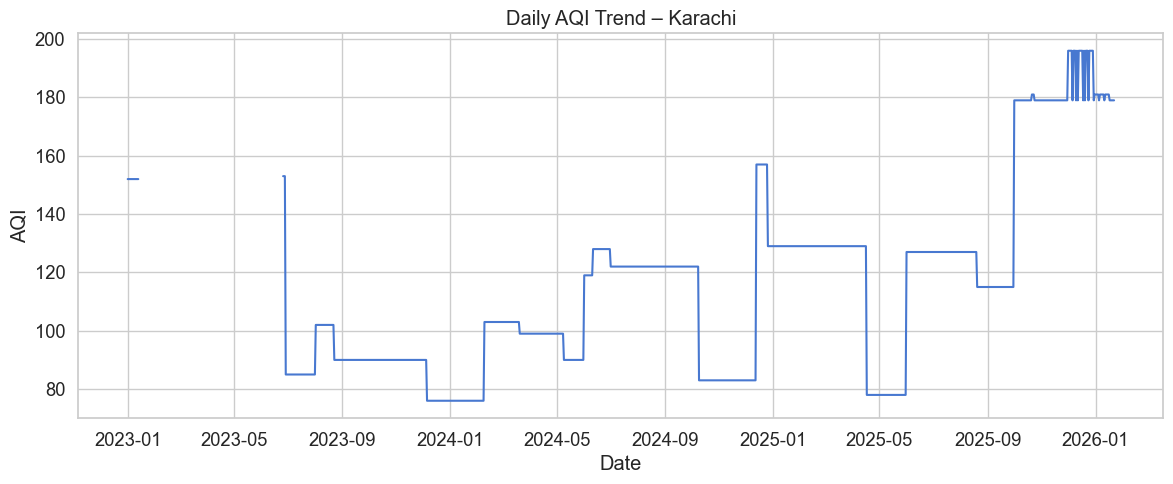

In [23]:
df_sorted = df.sort_values("date")

plt.figure(figsize=(14,5))
plt.plot(df_sorted["date"], df_sorted["aqi_avg"])
plt.title("Daily AQI Trend – Karachi")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()


In [24]:
q1 = df["aqi_avg"].quantile(0.25)
q3 = df["aqi_avg"].quantile(0.75)
iqr = q3 - q1

outliers = df[
    (df["aqi_avg"] < q1 - 1.5 * iqr) |
    (df["aqi_avg"] > q3 + 1.5 * iqr)
]

print("Number of potential outliers:", len(outliers))
outliers.sort_values("aqi_avg", ascending=False).head()


Number of potential outliers: 23


,_id,city,date,aqi_avg,aqi_max,aqi_min,created_at,humidity_avg,precipitation_sum,source_aqi,source_weather,temperature_avg,temperature_max,temperature_min,wind_speed_avg,timestamp,aqi_missing
61,6973de8c9080e275e71ebe33,Karachi,2025-12-01,196.0,None,None,2026-01-23 21:01:15.186,45,0.0,IQAir,Open-Meteo,21.3,27.1,16.0,10.6,2026-01-23 21:01:15.184,0
76,6973ded99080e275e71ebe42,Karachi,2025-12-16,196.0,None,None,2026-01-23 21:03:23.273,42,0.0,IQAir,Open-Meteo,22.3,28.1,17.5,14.1,2026-01-23 21:03:23.271,0
88,6973e2969080e275e71ebe5c,Karachi,2025-12-28,196.0,None,None,2026-01-23 21:05:26.536,43,0.0,IQAir,Open-Meteo,20.4,25.6,15.6,8.6,2026-01-23 21:05:26.535,0
87,6973e2959080e275e71ebe5b,Karachi,2025-12-27,196.0,None,None,2026-01-23 21:05:25.099,45,0.0,IQAir,Open-Meteo,20.2,25.5,15.1,10.5,2026-01-23 21:05:25.099,0
86,6973e2939080e275e71ebe5a,Karachi,2025-12-26,196.0,None,None,2026-01-23 21:05:24.004,63,0.0,IQAir,Open-Meteo,19.7,24.5,14.9,8.7,2026-01-23 21:05:24.003,0
